# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg, FacetNormal, CellDiameter
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler

/home/jamal/anaconda3/envs/pycutfem/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho = 1.0  # Density
mu = 1e-3  # Viscosity
U_mean = 1.0  # Mean inflow velocity
Re = rho * U_mean * D / mu
print(f"Reynolds number (Re): {Re:.2f}")

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
# NX, NY = 20, 20
NX, NY = 50, 60
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging
# h  = 0.5*(L/NX + H/NY)


# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=CircleLevelSet(center=(c_x, c_y), radius=(D/2.0+0.2*D/2.0) ),
        max_refine_level=1)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---

bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}



# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('ux', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('uy', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [4]:
# --- Level Set for the Cylinder Obstacle ---
mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
rigid_domain = get_domain_bitset(mesh, "element", "inside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = mesh.edge_bitset('ghost')
physical_domain = fluid_domain | cut_domain

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2, 'p': 1})
dof_handler = DofHandler(mixed_element, method='cg')
dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {mesh.edge_bitset('ghost').cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
print(f"Number of pos ghost edges: {mesh.edge_bitset('ghost_pos').cardinality()}")
print(f"Number of neg ghost edges: {mesh.edge_bitset('ghost_neg').cardinality()}")
print(f"Number of ghost edges (both): {mesh.edge_bitset('ghost_both').cardinality()}")


=== DofHandler (CG) ===
        ux: 16799 DOFs @ offset 0
        uy: 16799 DOFs @ offset 9
         p: 4266 DOFs @ offset 18
  total : 37864
Number of interface edges: 70
Number of ghost edges: 136
Number of cut elements: 70
Number of pos ghost edges: 74
Number of neg ghost edges: 58
Number of ghost edges (both): 4


In [5]:
dof_handler.tag_dof_by_locator(
    'p_pin', 'p',
    locator=lambda x, y: (x < 0.05 * L) and np.isclose(y, 0.5 * H),
    find_first=True
)
bcs.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x, y: 0.0))
# Tag velocity DOFs inside the cylinder (same tag name for both fields is OK)
dof_handler.tag_dofs_from_element_bitset("inactive", "ux", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "uy", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "p", "inside", strict=True)

bcs.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))

In [6]:
for name, bitset in mesh._edge_bitsets.items():
    print(f"Edge bitset '{name}': {bitset.cardinality()}")

Edge bitset 'ghost_both': 4
Edge bitset 'ghost_neg': 58
Edge bitset 'ghost_pos': 74
Edge bitset 'interface': 70
Edge bitset 'ghost': 136
Edge bitset 'inlet': 78
Edge bitset 'outlet': 78
Edge bitset 'walls': 106


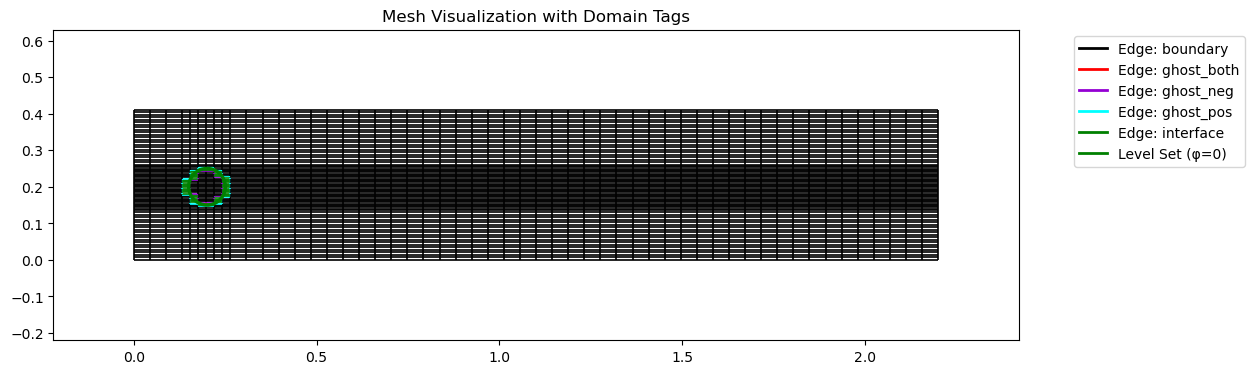

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [7]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [8]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_space = FunctionSpace(name="velocity", field_names=['ux', 'uy'],dim=1)
pressure_space = FunctionSpace(name="pressure", field_names=['p'], dim=0)

# Trial and Test functions
du = VectorTrialFunction(space=velocity_space, dof_handler=dof_handler)
dp = TrialFunction(name='trial_pressure', field_name='p', dof_handler=dof_handler)
v = VectorTestFunction(space=velocity_space, dof_handler=dof_handler)
q = TestFunction(name='test_pressure', field_name='p', dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Parameters ---
dt = Constant(0.25)
theta = Constant(0.5) # Crank-Nicolson
mu_const = Constant(mu)
rho_const = Constant(rho)

u_k.nodal_values.fill(0.0); p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0); p_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, u_n, p_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_n' as separate contour plots...


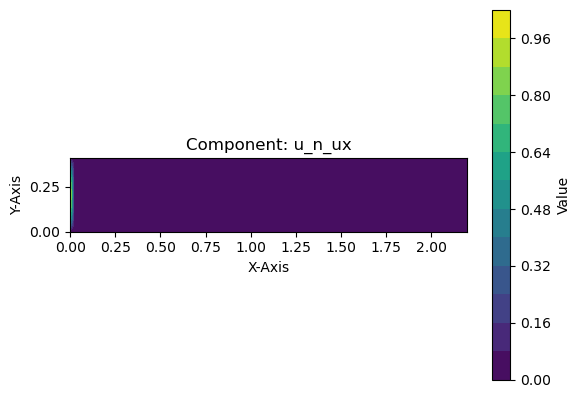

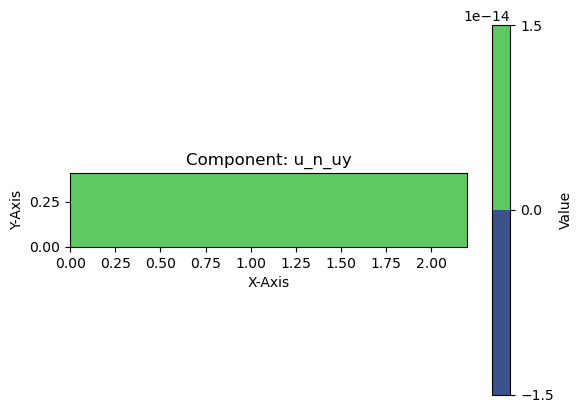

In [9]:
u_n.plot()

In [10]:
print(len(dof_handler.get_dirichlet_data(bcs)))

1281


In [11]:
len(dof_handler.get_dirichlet_data(bcs))

1281

In [12]:
import numpy as np

def make_peak_filter_cb(
    dh,
    level_set,
    *,
    fields=('ux', 'uy'),
    side='+',                 # '+' → φ>=0 (outside), '-' → φ<=0 (inside)
    band_width=1.0,           # keep nodes with |φ| <= band_width * h_dof
    tau=3.5,                  # MAD threshold
    skip_dofs=None            # set[int] of global DOFs to skip (e.g. active Dirichlet)
):
    """
    Robust outlier clamp for velocity components near the interface, operating in
    DOF space using only the DofHandler's numbering and maps.

    Usage:
        skip_active = set(dh.get_dirichlet_data(bcs).keys()) \
                      - set(dh.dof_tags.get('inactive', set()))
        cb = make_peak_filter_cb(dh, level_set, side='+', band_width=1.0,
                                 tau=3.5, skip_dofs=skip_active)
        solver = NewtonSolver(..., post_cb=cb)
    """
    if skip_dofs is None:
        skip_dofs = set()

    mesh = dh.mixed_element.mesh

    # -----------------------------------------------------------
    # 1) Build 1-ring DOF adjacency per field from element maps
    # -----------------------------------------------------------
    def _build_dof_adjacency(field):
        adj = {}  # gdof -> set(neighbour gdofs)
        elem_maps = dh.element_maps[field]            # per-element global DOFs (field)
        for gdofs in elem_maps:                       # list[int] for that element/field
            g = list(gdofs)
            for i in range(len(g)):
                ai = g[i]
                s = adj.setdefault(ai, set())
                for j in range(len(g)):
                    if i == j: continue
                    s.add(g[j])
        return adj

    adj_by_field = {f: _build_dof_adjacency(f) for f in fields}

    # -----------------------------------------------------------
    # 2) Coordinates and φ at DOFs (handler-driven, not mesh ids)
    # -----------------------------------------------------------
    # all DOF coords aligned with global DOF index
    all_coords = dh.get_all_dof_coords()             # shape (total_dofs, 2)  :contentReference[oaicite:11]{index=11}
    # φ evaluated vectorised (CircleLevelSet etc. support array input)
    phi_all = level_set(all_coords)

    # -----------------------------------------------------------
    # 3) Per-DOF h: mean element char length over adjacent elems
    # -----------------------------------------------------------
    # Build node -> {adjacent element ids} once (geometry graph),
    # then map gdof -> node id -> elems -> average h
    node_to_elems = {}
    for el in mesh.elements_list:
        for nid in el.nodes:
            node_to_elems.setdefault(nid, set()).add(el.id)

    g2n = dh._dof_to_node_map  # global dof -> (field, node_id)  :contentReference[oaicite:12]{index=12}

    def _h_for_gdof(gd):
        nid = g2n[gd][1]
        eids = node_to_elems.get(nid, ())
        if not eids:
            return mesh.element_char_length(0)
        return np.mean([mesh.element_char_length(e) for e in eids])

    # cache per-DOF h in a dict (sparse – only what we touch)
    h_cache = {}

    # -----------------------------------------------------------
    # 4) Band masks per field (by DOF), with side selection
    # -----------------------------------------------------------
    def _band_mask_for_field(field):
        gdofs = dh.get_field_slice(field)            # ascending global DOFs  :contentReference[oaicite:13]{index=13}
        phi_f = phi_all[gdofs]
        if side == '+':
            side_ok = (phi_f >= 0.0)
        elif side == '-':
            side_ok = (phi_f <= 0.0)
        else:
            raise ValueError("side must be '+' or '-'")
        # build h per gdof lazily
        h_f = np.empty_like(phi_f)
        for i, gd in enumerate(gdofs):
            if gd not in h_cache:
                h_cache[gd] = _h_for_gdof(gd)
            h_f[i] = h_cache[gd]
        band = (np.abs(phi_f) <= band_width * h_f) & side_ok
        return gdofs, band

    band_by_field = {f: _band_mask_for_field(f) for f in fields}

    # -----------------------------------------------------------
    # 5) The actual filter that edits a VectorFunction in-place
    # -----------------------------------------------------------
    from pycutfem.ufl.expressions import VectorFunction

    def _filter_on_vector(vf, field):
        gdofs, band = band_by_field[field]
        g2l = vf._g2l        # global→local map in that VectorFunction  :contentReference[oaicite:14]{index=14}
        vals = vf.nodal_values

        adj = adj_by_field[field]
        changed = 0

        # iterate only DOFs present in vf and within the band and not in skip list
        for gd, keep in zip(gdofs, band):
            if not keep:               # not in |φ|<=band_width*h or wrong side
                continue
            if gd in skip_dofs:        # e.g. active Dirichlet at walls/inlet/outlet
                continue
            li = g2l.get(gd, None)
            if li is None:             # vf may not carry this DOF (shouldn't happen)
                continue

            neigh = [n for n in adj.get(gd, ()) if n in g2l]
            if len(neigh) < 3:
                continue

            nvals = np.array([vals[g2l[n]] for n in neigh], float)
            med   = np.median(nvals)
            mad   = np.median(np.abs(nvals - med)) + 1e-14
            if abs(vals[li] - med) > tau * mad:
                vals[li] = med
                changed += 1
                dh._tmp_clamped_gdofs.add(gd)   # << NEW, remember this clamped gdof
                dh._tmp_clamped_vals[gd] = med         # NEW
        return changed

    # -----------------------------------------------------------
    # 6) The callback the Newton solver will call each iteration
    # -----------------------------------------------------------
    def _cb(funcs):
        # Reset a per-call scratch set the solver can read afterwards
        dh._tmp_clamped_gdofs = set()     # << NEW
        dh._tmp_clamped_vals = {}
        # Expect a VectorFunction (velocity) and a scalar Function (pressure) in funcs.
        from pycutfem.ufl.expressions import VectorFunction
        vf = next((f for f in funcs if isinstance(f, VectorFunction)), None)
        if vf is None:
            return
        total = 0
        for f in fields:
            total += _filter_on_vector(vf, f)
        if total:
            print(f"        [peak-filter] clamped {total} DOFs in |φ|≤{band_width}h on side '{side}'")

    return _cb


In [13]:
from matplotlib import scale
from pycutfem.ufl.expressions import Derivative, FacetNormal, restrict
from pycutfem.core.geometry import hansbo_cut_ratio
from pycutfem.ufl.expressions import ElementWiseConstant

n = FacetNormal()                    # vector expression (n_x, n_y)
n_f = FacetNormal()                  # vector expression (n_x, n_y) on the fluid side

def _dn(expr):
    """Normal derivative  n·∇expr  on an (interior) edge."""
    Dx = Derivative(expr, 1, 0)
    Dy = Derivative(expr, 0, 1)
    _ = Dx + Dy
    return n[0]*Dx + n[1]*Dy

def grad_inner(u, v):
    """⟨∂ₙu, ∂ₙv⟩  (scalar or 2‑D vector)."""
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _dn(u) * _dn(v)

    if u.num_components == v.num_components == 2: # vector
        return _dn(u[0]) * _dn(v[0]) + _dn(u[1]) * _dn(v[1])

    raise ValueError("grad_inner supports only scalars or 2‑D vectors.")
ghost_edges_used = mesh.edge_bitset('ghost_pos') | mesh.edge_bitset('ghost_both') | mesh.edge_bitset('interface')
dx_phys  = dx(defined_on=physical_domain, 
              level_set=level_set,            # the cylinder level set
              metadata   = {"q": 7, "side": "+"} # integrate only φ>0 (positive side)
    )
dΓ        = dInterface(defined_on=mesh.element_bitset('cut'), level_set=level_set, metadata={"q":9})   # interior surface
dG       = dGhost(defined_on=ghost_edges_used, level_set=level_set,metadata={"q":6,'derivs': {(0,1),(1,0)}})  # ghost surface

cell_h  = CellDiameter() # length‑scale per element
beta_N  = Constant(20.0 * poly_order**2)      # Nitsche penalty (tweak)
def scaled_penalty_interface(penalty,poly_order =poly_order,
                             side='+'):
    # 1) Hansbo factor — this is a *numpy array*, one value per element
    beta0_val  = penalty * poly_order**2
    theta_min  = 1.0e-3
    hansbo_plus = hansbo_cut_ratio(mesh, level_set, side=side)    # -> np.ndarray, shape (n_elem,)
    hansbo_plus = np.clip(hansbo_plus, theta_min, 1.0)
    alpha = 0.5
    beta_hansbo_arr = beta0_val * hansbo_plus**(-alpha)
    β_visc = ElementWiseConstant(beta_hansbo_arr) * (mu_const / cell_h)
    β_iner = beta0_val * (rho_const * cell_h / dt)        # no θ-scaling here

    # 3) Final penalty (symbolic EWC × expression)
    return β_visc + β_iner
β = scaled_penalty_interface(30.0, side='+')  # Nitsche penalty

def epsilon(u):
    "Symmetric gradient."
    return 0.5 * (grad(u) + grad(u).T)

# def sigma_dot_n(u_vec, p_scal):
#     """
#     Expanded form of (σ(u, p) · n) without using the '@' operator.

#         σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
#     """
#     # first term: μ (∇u)·n
#     a = dot(grad(u_vec), n)
#     # second term: μ (∇uᵀ)·n
#     b = dot(grad(u_vec).T, n)
#     # combine and subtract pressure part
#     return mu * (a + b) - p_scal * n         # vector of size 2

def sigma_dot_n_v(u_vec, p_scal,v_test,n):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return  mu * dot((a + b),v_test) - p_scal * dot(v_test,n)         # vector of size 2

# --- Jacobian contribution on Γsolid --------------------------------
J_int = (
    - sigma_dot_n_v(du, dp, v,n_f)           # consistency
    - sigma_dot_n_v(v, q, du,n_f)           # symmetry
    # + beta_N  / cell_h * dot(du, v)     # penalty
    # - dot(du,n) * q
    # + beta_N/ cell_h * dot(du,n) * dot(v,n)     # penalty
    + β  * dot(du, v)     # penalty
) * dΓ

# --- Residual contribution on Γsolid --------------------------------
R_int = (
    - sigma_dot_n_v(u_k, p_k, v,n_f)
    - sigma_dot_n_v(v, q, u_k,n_f)
    # + beta_N  / cell_h * dot(u_k, v)
    # - dot(u_k,n) * q
    # + beta_N/ cell_h * dot(u_k,n) * dot(v,n)
    + β  * dot(u_k, v)  
) * dΓ

# volume ------------------------------------------------------------
# a_vol = restrict(( rho*dot(du,v)/dt
#           + theta*rho*dot(dot(grad(u_k), du), v)
#           + theta*rho*dot(dot(grad(du), u_k), v)
#           + theta*mu*inner(grad(du), grad(v))
#           - dp*div(v) + q*div(du) ),physical_domain) * dx_phys

# r_vol = restrict(( rho*dot(u_k-u_n, v)/dt
#           + theta*rho*dot(dot(grad(u_k), u_k), v)
#           + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
#           + theta*mu*inner(grad(u_k), grad(v))
#           + (1-theta)*mu*inner(grad(u_n), grad(v))
#           - p_k*div(v) + q*div(u_k) ),physical_domain) * dx_phys
a_vol = ( rho*dot(du,v)/dt
          + theta*rho*dot(dot(grad(u_k), du), v)
          + theta*rho*dot(dot(grad(du), u_k), v)
          + 2 * theta*mu*inner(epsilon(du), epsilon(v))
          - dp*div(v) + q*div(du) ) * dx_phys

r_vol = ( rho*dot(u_k-u_n, v)/dt
          + theta*rho*dot(dot(grad(u_k), u_k), v)
          + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
          + 2 * theta*mu*inner(epsilon(u_k), epsilon(v))
          + 2 * (1-theta)*mu*inner(epsilon(u_n), epsilon(v))
          - p_k*div(v) + q*div(u_k) ) * dx_phys
          
# ghost stabilisation (add exactly as in your Poisson tests) --------
penalty_val = 0.1
penalty_grad = 0.1
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad= Constant(penalty_grad * poly_order**2)
gamma_p  = Constant(penalty_val * poly_order**1)
gamma_p_grad = Constant(penalty_grad * poly_order**1)

stab = ( gamma_v  / cell_h   * dot(jump(u_k), jump(v))
       + gamma_v_grad * cell_h   * grad_inner(jump(u_k), jump(v))
       + gamma_p  / cell_h   * jump(p_k) * jump(q)  # Note: use * for scalars, see issue 2
       + gamma_p_grad * cell_h   * grad_inner(jump(p_k), jump(q)) ) * dG

stab_lin  = (( gamma_v  / cell_h   * dot(jump(du),  jump(v)) +
             gamma_v_grad * cell_h   * grad_inner(jump(du),  jump(v))) 
           + ( gamma_p  / cell_h   * jump(dp) *  jump(q)
            + gamma_p_grad * cell_h   * grad_inner(jump(dp),  jump(q)))  ) * dG
# complete Jacobian and residual -----------------------------------
jacobian_form  = a_vol + J_int + stab_lin
residual_form  = r_vol + R_int + stab
# residual_form  = dot(  Constant(np.array([0.0, 0.0]),dim=1), v) * dx
# jacobian_form  = stab_lin
# residual_form  = stab





In [14]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [15]:
from pycutfem.io.vtk import export_vtk
from pycutfem.ufl.compilers import FormCompiler
from pycutfem.ufl.forms import Equation, assemble_form
from pycutfem.fem import transform
output_dir = "turek_results"
os.makedirs(output_dir, exist_ok=True)
step_counter = 0
histories = {}  # Store histories for CD, CL, Δp
# --- Traction helper on Γ: (σ(u,p)·n)·v_dir  -------------------------------
# Uses the same σ as in your Nitsche terms: μ(∇u + ∇uᵀ) - p I
def traction_dot_dir(u_vec, p_scal, v_dir):
    # n is provided by the interface/boundary assembler via FacetNormal()
    a = dot(grad(u_vec),   n)      # (∇u)·n
    b = dot(grad(u_vec).T, n)      # (∇uᵀ)·n
    t = mu*(a + b) - p_scal*n      # σ(u,p)·n   (vector in ℝ²)
    return dot(t, v_dir)           # scalar: (σ·n)·e_x or (σ·n)·e_y


def save_solution(funcs):
    """Export + compute CD, CL, Δp (Turek)."""
    global step_counter

    u_k_func = funcs[0]
    p_k_func = funcs[1]

    # ------------------ VTK output (as you already have) --------------------
    filename = os.path.join(output_dir, f"solution_{step_counter:04d}.vtu")
    export_vtk(
        filename=filename,
        mesh=mesh,
        dof_handler=dof_handler,
        functions={"velocity": u_k_func, "pressure": p_k_func}
    )

    # ------------------ Interface integrals for Drag & Lift -----------------
    # High-order quadrature helps here (Q2 velocity): use q≈11–13
    dΓ = dInterface(defined_on=cut_domain, level_set=level_set, metadata={"q": 11})

    e_x = Constant(np.array([1.0, 0.0]), dim =1)
    e_y = Constant(np.array([0.0, 1.0]), dim =1)

    # traction on the *fluid* side, then flip the sign to get the force on the cylinder
    integrand_drag = -traction_dot_dir(u_k_func, p_k_func, e_x)   # scalar
    integrand_lift = -traction_dot_dir(u_k_func, p_k_func, e_y)   # scalar

    I_drag = integrand_drag * dΓ
    I_lift = integrand_lift * dΓ

    # Assemble the two scalar functionals using the compiler “hooks”
    hooks = {
        I_drag.integrand: {"name": "FD"},
        I_lift.integrand: {"name": "FL"},
    }
    drag_hook = {I_drag.integrand: {"name": "FD"}}
    lift_hook = {I_lift.integrand: {"name": "FL"}}

    res_Fd = assemble_form(I_drag == Constant(0.0) * dx, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=drag_hook, backend="python")
    res_Fl = assemble_form(I_lift == Constant(0.0) * dx, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=lift_hook, backend="python")

    F_D = float(res_Fd["FD"])
    F_L = float(res_Fl["FL"])

    # Dimensionless coefficients (DFG definition)
    coeff = 2.0 / (rho * (U_mean**2) * D)
    C_D = coeff * F_D
    C_L = coeff * F_L

    # ------------------ Pressure difference Δp = p(A) - p(B) ----------------
    # ------------------ Pressure difference Δp = p(A) - p(B) ----------------
    def eval_scalar_at_point(f_scalar, x, y):
        """
        Robustly evaluates a scalar field at a point (x,y),
        ensuring the point is in the physical domain.
        """
        xy = np.array([x, y])

        # 1. First, check if the point is in the physical domain.
        if level_set(xy) < 0:
            print(f"Warning: Point ({x},{y}) is in the fictitious domain (phi < 0). Returning NaN.")
            return np.nan

        # 2. Find the element that contains the point.
        eid_found = None
        for e in mesh.elements_list:
            # Skip elements that are fully inside the cylinder
            if getattr(e, "tag", None) == "inside":
                continue

            # Check if the point is geometrically within the element's bounding box first for efficiency
            v_coords = mesh.nodes_x_y_pos[list(e.corner_nodes)]
            if not (v_coords[:, 0].min() <= x <= v_coords[:, 0].max() and \
                    v_coords[:, 1].min() <= y <= v_coords[:, 1].max()):
                continue

            # Perform precise inverse mapping
            try:
                xi, eta = transform.inverse_mapping(mesh, e.id, xy)
                if -1e-9 <= xi <= 1 + 1e-9 and -1e-9 <= eta <= 1 + 1e-9:
                    eid_found = e.id
                    break
            except (np.linalg.LinAlgError, ValueError):
                continue # Point is outside this element.
        
        if eid_found is None:
            # print(f"Warning: Point ({x},{y}) could not be located in any physical element. Returning NaN.")
            return np.nan

        # 3. Evaluate the field using basis functions at the found reference coords.
        phi = mixed_element.basis(f_scalar.field_name, xi, eta)
        gdofs = dof_handler.get_elemental_dofs(eid_found)
        vals = f_scalar.get_nodal_values(gdofs)
        return float(phi @ vals)

    # Evaluate pressure slightly away from the cylinder boundary for stability.
    # Cylinder is at (0.2, 0.2) with radius 0.05.
    pA = eval_scalar_at_point(p_k_func, c_x - D/2 - 0.01, c_y) # Front point
    pB = eval_scalar_at_point(p_k_func, c_x + D/2 + 0.01, c_y) # Rear point
    dp = pA - pB

    # ------------------ Log / store ----------------------------------------
    print(f"[step {step_counter:4d}]  FD={F_D:.6e}  FL={F_L:.6e}  "
          f"CD={C_D:.6f}  CL={C_L:.6f}  Δp={dp:.6f}")
    if step_counter % 5 == 0:
        u_k_func.plot(field = 'ux',
                      title=f"Velocity Ux at step {step_counter}",
                      xlabel='X-Axis', ylabel='Y-Axis',
                      levels=100, cmap='jet',
                      mask = fluid_domain,)

    # (Optional) append to global histories for later plotting
    histories.setdefault("cd", []).append(C_D)
    histories.setdefault("cl", []).append(C_L)
    histories.setdefault("dp", []).append(dp)


    step_counter += 1



points shape: (42, 2), weights shape: (42,)
Found 70 valid cut elements for cut volume.
JIT cache miss → compiling _pycutfem_kernel_3867af692db2a0b350f859ed7646023e9316de866a30be6aa112456581d1e0d0.py
Found 70 valid cut elements for cut volume.
JIT cache miss → compiling _pycutfem_kernel_e6c3b1f5d47f1b0ddc23baf387e6a78054ba09bed69de13504530ff3f4a267d4.py
No Restriction operators found. All DOFs are considered active.
NewtonSolver: Reduced system with 36583/37864 DOFs.
  Dirichlet DOFs detected: 1281; Free DOFs: 36583
  0 SNES VI Function norm 6.19619 Active lower constraints 0/0 upper constraints 0/0 Percent of total 0. Percent of bounded 0.  1 SNES VI Function norm 1.42398 Active lower constraints 31/48 upper constraints 22/41 Percent of total 0.00144876 Percent of bounded 0.00144876
  2 SNES VI Function norm 1.30353 Active lower constraints 30/35 upper constraints 23/28 Percent of total 0.00144876 Percent of bounded 0.00144876
  3 SNES VI Function norm 0.105164 Active lower constraint

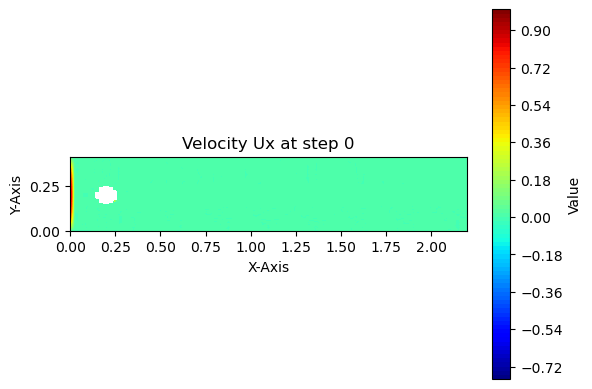

  0 SNES VI Function norm 6.19625 Active lower constraints 0/0 upper constraints 0/0 Percent of total 0. Percent of bounded 0.  1 SNES VI Function norm 1.42453 Active lower constraints 31/48 upper constraints 22/41 Percent of total 0.00144876 Percent of bounded 0.00144876
  2 SNES VI Function norm 1.30405 Active lower constraints 30/35 upper constraints 23/28 Percent of total 0.00144876 Percent of bounded 0.00144876
  3 SNES VI Function norm 0.106334 Active lower constraints 14/36 upper constraints 18/30 Percent of total 0.000874723 Percent of bounded 0.000874723
  4 SNES VI Function norm 0.106215 Active lower constraints 18/30 upper constraints 21/26 Percent of total 0.00106607 Percent of bounded 0.00106607
  5 SNES VI Function norm 0.101732 Active lower constraints 27/29 upper constraints 23/28 Percent of total 0.00136676 Percent of bounded 0.00136676
  6 SNES VI Function norm 0.0889371 Active lower constraints 27/32 upper constraints 21/28 Percent of total 0.00131208 Percent of boun

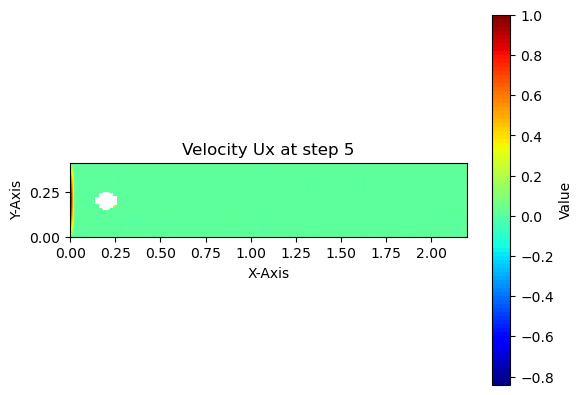

  0 SNES VI Function norm 6.19625 Active lower constraints 0/0 upper constraints 0/0 Percent of total 0. Percent of bounded 0.  1 SNES VI Function norm 1.42451 Active lower constraints 31/48 upper constraints 22/41 Percent of total 0.00144876 Percent of bounded 0.00144876
  2 SNES VI Function norm 1.30404 Active lower constraints 30/35 upper constraints 23/28 Percent of total 0.00144876 Percent of bounded 0.00144876
  3 SNES VI Function norm 0.106436 Active lower constraints 14/36 upper constraints 18/30 Percent of total 0.000874723 Percent of bounded 0.000874723
  4 SNES VI Function norm 0.106317 Active lower constraints 18/30 upper constraints 21/26 Percent of total 0.00106607 Percent of bounded 0.00106607
  5 SNES VI Function norm 0.101789 Active lower constraints 27/29 upper constraints 23/28 Percent of total 0.00136676 Percent of bounded 0.00136676
  6 SNES VI Function norm 0.0888956 Active lower constraints 27/32 upper constraints 21/28 Percent of total 0.00131208 Percent of boun

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.17941109e-20, -7.78156025e-22,  1.42976855e-19], shape=(37864,)),
 7,
 2803.696061225026)

In [16]:
from pycutfem.solvers.nonlinear_solver import (NewtonSolver, 
                                               NewtonParameters, 
                                               TimeStepperParameters, 
                                               AdamNewtonSolver,
                                               PetscSnesNewtonSolver)
from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")


# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=50 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)
dirichlet_dofs = set(dof_handler.get_dirichlet_data(bcs).keys())  # bcs = your Dirichlet BCs
post_cb = make_peak_filter_cb(
    dof_handler, level_set,
    fields=("ux","uy"),      # or ("ux","uy","p") if you want to smooth pressure too
    side='+',                 # use '+' if Ω = {φ>0}, '-' if Ω = {φ<0}
    band_width=0.5,           # in units of h
    tau=5.0,
    skip_dofs=dirichlet_dofs
)

# solver = NewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
#     postproc_timeloop_cb=save_solution,
#     # preproc_cb=post_cb,  # Optional: peak filter callback
# )
solver = PetscSnesNewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True,
                                   max_newton_iter=500),
    postproc_timeloop_cb=save_solution,
    petsc_options={
        "snes_type": "vinewtonrsls",     # VI Newton (Reduced-Space)
        "snes_vi_monitor": None,         # optional: see active set info
        "snes_linesearch_type": "bt",    # OK with VI
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "snes_converged_reason": None,
    },)
solver.set_box_bounds(by_field={
    "ux": (-2.0, 2.0),
    "uy": (-2.0, 2.0),
    "p":  (None,  None),   # p ≥ 0
})
# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

Text(0, 0.5, 'Δp')

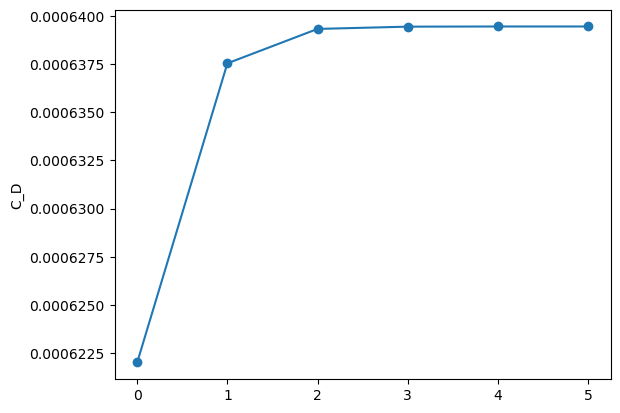

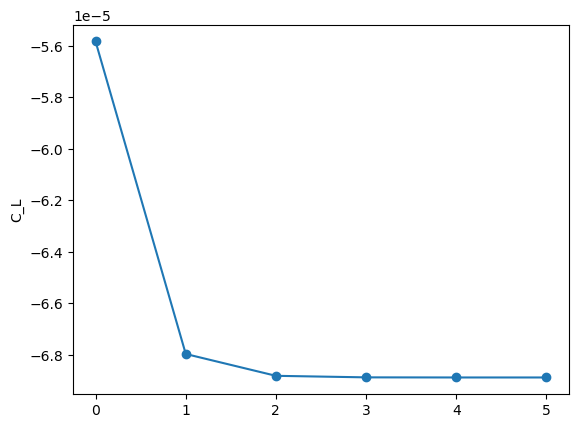

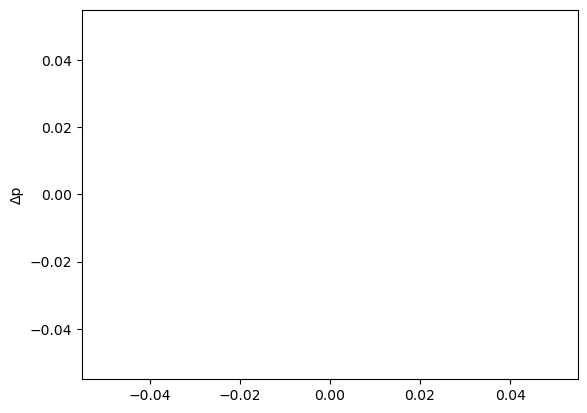

In [17]:
plt.plot(histories["cd"], label="C_D", marker='o')
plt.ylabel('C_D')
plt.figure()
plt.plot(histories["cl"], label="C_L", marker='o')
plt.ylabel('C_L')
plt.figure()
plt.plot(histories["dp"], label="Δp", marker='o')
plt.ylabel('Δp')

Plotting all components of 'u_n' as separate contour plots...


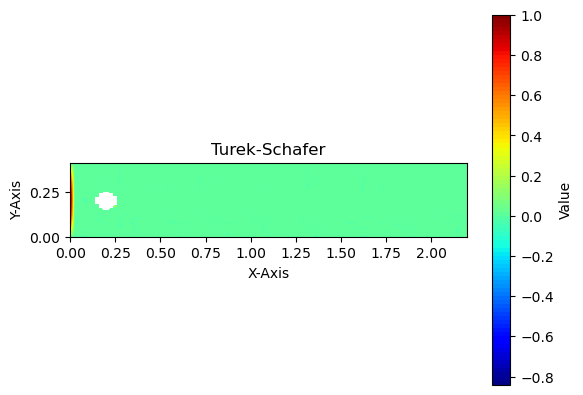

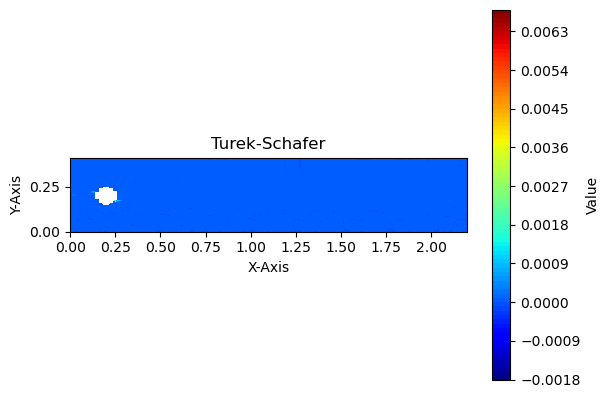

In [18]:


u_n.plot(kind="contour",mask =fluid_domain,
         title="Turek-Schafer",
         xlabel='X-Axis', ylabel='Y-Axis',
         levels=100, cmap='jet')

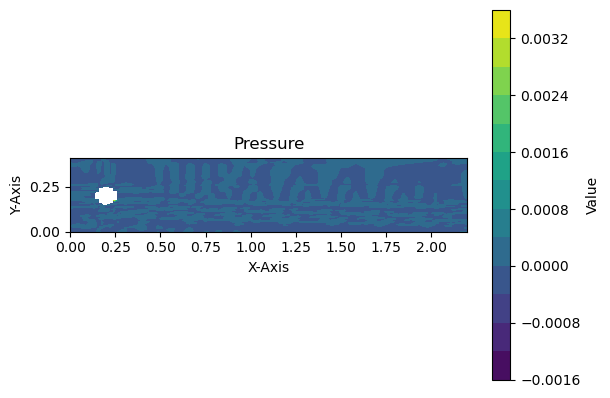

In [19]:
p_n.plot(
         title="Pressure",mask =fluid_domain)